In [107]:
# Dependencies and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [108]:
# Reading the files.
cleaned_df = pd.read_csv("Resources//Data//homerent_cleaneddata_zip.csv", index_col= "Date", parse_dates=True)

# Home_price.Newyork=np.ceil(Home_price.Newyork).astype(int)
# Dataframe  for rent data
df = cleaned_df
df

,10458,60608,23464,92592
Date,,,,
2015-03-31,1185.0,1223.0,1328.0,1820.0
2015-04-30,1202.0,1217.0,1320.0,1844.0
2015-05-31,1195.0,1219.0,1319.0,1858.0
2015-06-30,1206.0,1256.0,1320.0,1851.0
2015-07-31,1220.0,1253.0,1332.0,1853.0
...,...,...,...,...
2022-07-31,1773.0,1555.0,1835.0,2995.0
2022-08-31,1732.0,1564.0,1848.0,3003.0
2022-09-30,1791.0,1569.0,1838.0,3024.0


## Auto Training for multiple Zip codes.


In [109]:
# List_Zip = ["77449","77494","11385","77084","11109"]
#list_zip = df.columns

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=846.048, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=844.339, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=845.307, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=852.867, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=843.196, Time=0.04 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=844.437, Time=0.09 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.31 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=845.120, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=845.180, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=844.160, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=844.504, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12]             : AIC=846.625, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,0,0)[12] intercept
Total fit time: 1.441 seconds
 For Zipcode 10458 RMSE Score

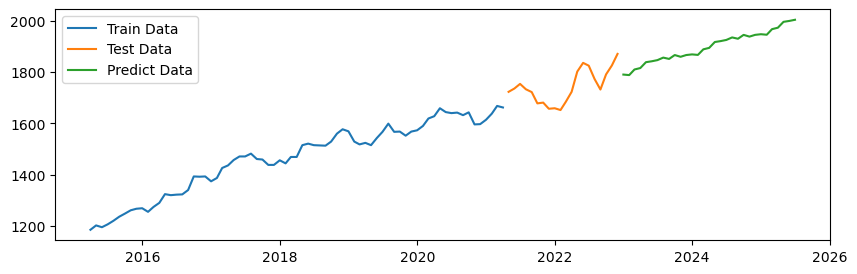

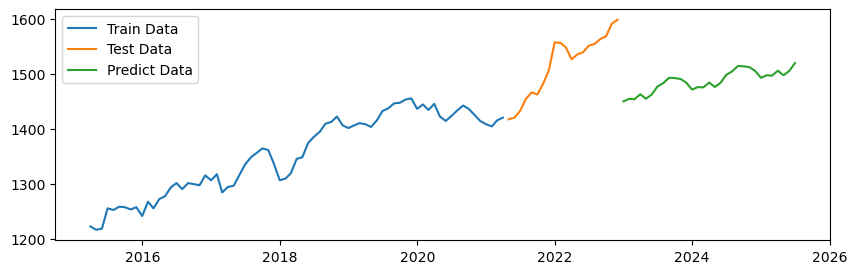

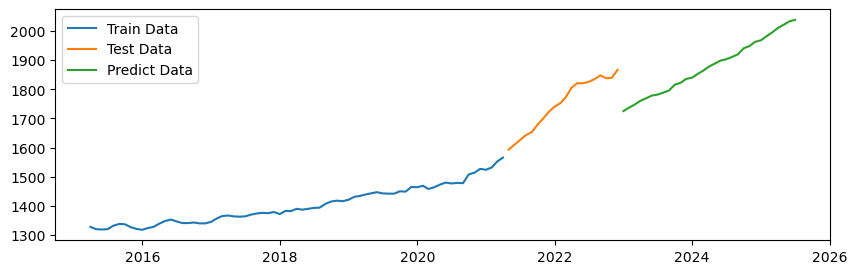

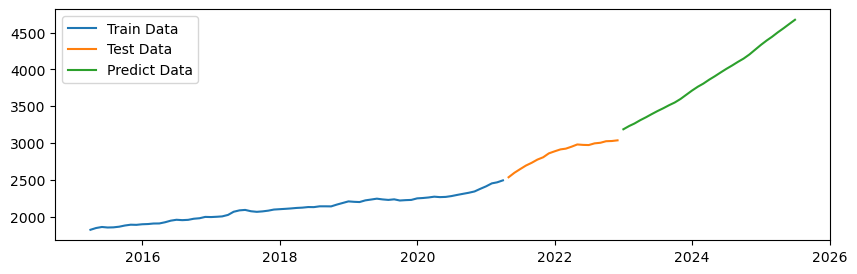

In [110]:
list_zip = df.columns
Best_model = {}
train_data = {}
test_data = {}
models = {}
df2  = pd.DataFrame()
for zip_code in list_zip:
    data = df[zip_code]
    train=data.iloc[:-20]
    test=data.iloc[-20:]
    stepwise_fit = auto_arima(data, trace=True,seasonal = True, m= 12, supress_warnings=True)
    best_order = stepwise_fit.get_params()["order"]
    model=SARIMAX(train,order = best_order,seasonal_order = (0,1,1,12))
    model=model.fit()
    models[zip_code] = model
    train_data[zip_code] = train
    test_data[zip_code] = test
    future_pred=models[zip_code].predict(start=93,end=93+30,type="levels")
    plt.figure(figsize=(10,3))
    plt.plot(train_data[zip_code].index, train_data[zip_code].values,label="Train Data" )
    plt.plot(test_data[zip_code].index, test_data[zip_code].values,label="Test Data"  )
    plt.plot(future_pred.index, future_pred.values,label="Predict Data"  )
    plt.legend( loc="upper left")
    start=len (train_data[zip_code])
    end=len(train_data[zip_code])+len(test_data[zip_code])-1
    pred=models[zip_code].predict(start=start,end=end,type="levels")
    rmse=sqrt(mean_squared_error(pred,test_data[zip_code]))
    print( f' For Zipcode {zip_code} RMSE Score is {int(rmse)}' )
    rmse=sqrt(mean_squared_error(pred,test_data[zip_code]))
    if int(rmse) < 250:
        
        plt.savefig(f'Images/{zip_code}_{int(rmse)}.jpg')
        pickle.dump(models[zip_code], open(f'Models/{zip_code}.pkl', 'wb'))
        pickled_model = pickle.load(open(f'Models/{zip_code}.pkl', 'rb'))
        #pred = pickled_model.predict(start=93,end=93+30,type="levels").rename("SARIMA PREDICTION")
        #print( f' For Zipcode {pred} RMSE Score is {(pred)}' )
        stodf = future_pred.to_frame().reset_index()
        stodf.rename(columns = {'predicted_mean':'FutureRent' , 'index':'month'},inplace=True)
        stodf = stodf.assign(zipcode=zip_code)
        columnsTitles = ['zipcode', 'month', 'FutureRent']
        stodf = stodf.reindex(columns=columnsTitles)
        v= stodf["zipcode"][1] # Takinf first value from list.
        df2["Date"] = stodf["month"]
        df2["ZipCode"] = stodf["FutureRent"]
        df2.rename(columns = {"ZipCode": v}, inplace = True)
        
        #print( f' For Zipcode {stodf} RMSE Score is {(stodf)}' )
        


In [111]:
df2.set_index("Date", inplace = True)
df3 = df2.round()
df3

,10458,60608,23464,92592
Date,,,,
2022-12-31,1790.0,1451.0,1725.0,3187.0
2023-01-31,1788.0,1455.0,1738.0,3231.0
2023-02-28,1810.0,1455.0,1747.0,3265.0
2023-03-31,1816.0,1464.0,1760.0,3310.0
2023-04-30,1839.0,1455.0,1769.0,3349.0
2023-05-31,1842.0,1463.0,1779.0,3393.0
2023-06-30,1847.0,1478.0,1782.0,3434.0
2023-07-31,1857.0,1484.0,1789.0,3472.0
2023-08-31,1851.0,1494.0,1796.0,3514.0


In [98]:
df_concat = pd.concat([df, df3], axis = 0)
df_concat

,10458,60608,23464,92592
Date,,,,
2015-03-31,1185.0,1223.0,1328.0,1820.0
2015-04-30,1202.0,1217.0,1320.0,1844.0
2015-05-31,1195.0,1219.0,1319.0,1858.0
2015-06-30,1206.0,1256.0,1320.0,1851.0
2015-07-31,1220.0,1253.0,1332.0,1853.0
...,...,...,...,...
2025-02-28,1967.0,1497.0,1995.0,4444.0
2025-03-31,1973.0,1506.0,2010.0,4505.0
2025-04-30,1996.0,1498.0,2021.0,4560.0


In [99]:
# Storing the data to csv 
file = df_concat.to_csv("Resources//Data//Four_ZipCode.csv")